Set Up and Imports

In [ ]:
# Core data & math tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine-learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Deep-learning framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Explainability
!pip install shap
import shap

import joblib



Load Dataset

In [ ]:
df = pd.read_csv('/content/heart_disease_health_indicators_BRFSS70k.csv')

print(df.head())
print(df.info())


   id  target  HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  Diabetes  \
0   1       0       1         1          1   40       1       0         0   
1   2       0       0         0          0   25       1       0         0   
2   3       0       1         1          1   28       0       0         0   
3   4       0       1         0          1   27       0       0         0   
4   5       0       1         1          1   24       0       0         0   

   PhysActivity  ...  AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  \
0             0  ...              1            0        5        18        15   
1             1  ...              0            1        3         0         0   
2             0  ...              1            1        5        30        30   
3             1  ...              1            0        2         0         0   
4             1  ...              1            0        2         3         0   

   DiffWalk  Sex  Age  Education  Income  
0      

Pre-process the Data

In [ ]:
# Drop any ID column if present
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# Handle missing values (basic example)
df = df.dropna()

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Normalize numeric features for stable training
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create dataloaders for batching
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


MLP Architecture

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()    # probability output between 0 and 1
        )

    def forward(self, x):
        return self.net(x)

# Create the model
input_dim = X_train.shape[1]
model = MLPModel(input_dim)
print(model)


MLPModel(
  (net): Sequential(
    (0): Linear(in_features=21, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


Train Model

In [ ]:
# Loss & optimizer
criterion = nn.BCELoss()            # Binary Cross-Entropy for 0/1
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()               # reset gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()                     # compute gradients
        optimizer.step()                    # update weights
        running_loss += loss.item()

    # Evaluate after each epoch
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        acc = accuracy_score(y_test, (preds > 0.5).int())
    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Test Acc: {acc:.4f}")


Epoch 1/50 | Loss: 0.2415 | Test Acc: 0.9075
Epoch 2/50 | Loss: 0.2370 | Test Acc: 0.9076
Epoch 3/50 | Loss: 0.2363 | Test Acc: 0.9073
Epoch 4/50 | Loss: 0.2359 | Test Acc: 0.9074
Epoch 5/50 | Loss: 0.2355 | Test Acc: 0.9071
Epoch 6/50 | Loss: 0.2352 | Test Acc: 0.9070
Epoch 7/50 | Loss: 0.2349 | Test Acc: 0.9073
Epoch 8/50 | Loss: 0.2346 | Test Acc: 0.9069
Epoch 9/50 | Loss: 0.2343 | Test Acc: 0.9073
Epoch 10/50 | Loss: 0.2339 | Test Acc: 0.9069
Epoch 11/50 | Loss: 0.2339 | Test Acc: 0.9070
Epoch 12/50 | Loss: 0.2335 | Test Acc: 0.9067
Epoch 13/50 | Loss: 0.2333 | Test Acc: 0.9067
Epoch 14/50 | Loss: 0.2331 | Test Acc: 0.9066
Epoch 15/50 | Loss: 0.2330 | Test Acc: 0.9067
Epoch 16/50 | Loss: 0.2328 | Test Acc: 0.9067
Epoch 17/50 | Loss: 0.2325 | Test Acc: 0.9065
Epoch 18/50 | Loss: 0.2323 | Test Acc: 0.9067
Epoch 19/50 | Loss: 0.2320 | Test Acc: 0.9057
Epoch 20/50 | Loss: 0.2319 | Test Acc: 0.9063
Epoch 21/50 | Loss: 0.2316 | Test Acc: 0.9071
Epoch 22/50 | Loss: 0.2314 | Test Acc: 0.90

Evaluate Performance

In [ ]:
model.eval()
with torch.no_grad():
    preds = model(X_test)
    y_pred = (preds > 0.5).int()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, preds))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9055108798486282
ROC AUC: 0.8426364496050861
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     45957
         1.0       0.49      0.11      0.17      4779

    accuracy                           0.91     50736
   macro avg       0.70      0.55      0.56     50736
weighted avg       0.87      0.91      0.88     50736

Confusion Matrix:
 [[45439   518]
 [ 4276   503]]


Explain Prediction with SHAP

/tmp/ipython-input-2974130081.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  shap_values = explainer.shap_values(torch.tensor(test_samples, dtype=torch.float32))


SHAP values shape: (50, 21, 1)
Test samples shape: torch.Size([50, 21])


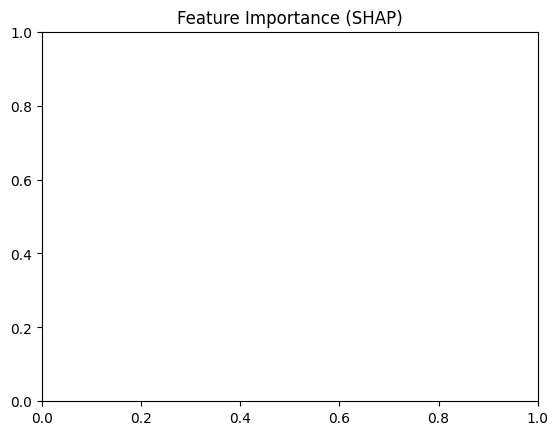

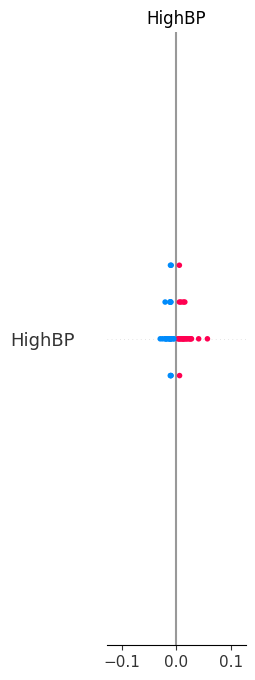

In [ ]:
# --- Prepare background and test tensors safely ---
background = X_train[:200].detach().clone()
test_samples = X_test[:50]

# --- Initialize SHAP explainer ---
explainer = shap.DeepExplainer(model, background)

# --- Compute SHAP values ---
shap_values = explainer.shap_values(torch.tensor(test_samples, dtype=torch.float32))

# --- Handle shape differences automatically ---
if isinstance(shap_values, list):
    shap_values = shap_values[0]
if shap_values.ndim == 3 and shap_values.shape[1] == 1:
    shap_values = shap_values.squeeze(1)

print("SHAP values shape:", shap_values.shape)
print("Test samples shape:", test_samples.shape)

# --- Plot SHAP summary ---
plt.title("Feature Importance (SHAP)")
shap.summary_plot(shap_values, test_samples, feature_names=X.columns)


Test with Patient's Data

In [ ]:
# Define new patient data in same order as training columns
new_patient = np.array([[130,1,1,29.4,0,0,0,1,1,1,0,1,0,3,2,2,0,1,9,4,5]])

# Scale using the saved scaler
new_patient_scaled = scaler.transform(new_patient)

# Convert to tensor
new_patient_tensor = torch.tensor(new_patient_scaled, dtype=torch.float32)

# Predict
with torch.no_grad():
    prediction = model(new_patient_tensor)
    risk_prob = prediction.item()
    risk_class = 1 if risk_prob > 0.5 else 0

print(f"Predicted Risk Probability: {risk_prob:.3f}")
print(f"Predicted Class: {risk_class} (1 = Disease, 0 = No Disease)")


Predicted Risk Probability: 0.000
Predicted Class: 0 (1 = Disease, 0 = No Disease)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Explain Test Prediction with SHAP

SHAP shape: (1, 21, 1)
Feature shape: torch.Size([1, 21])
Equal length? True


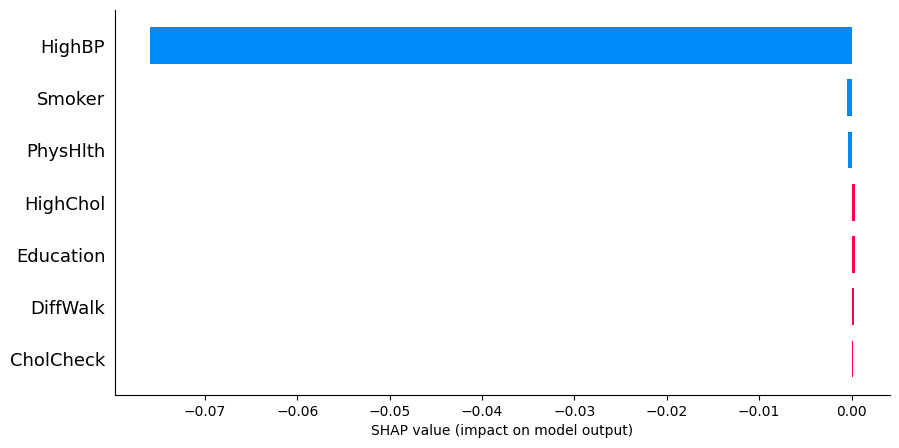

In [ ]:

# --- Prepare background data (safe copy) ---
background = X_train[:200].detach().clone()

# --- Create SHAP explainer ---
explainer = shap.DeepExplainer(model, background)

# --- Compute SHAP values for the single patient ---
shap_values = explainer.shap_values(new_patient_tensor)

# --- Check shapes ---
print("SHAP shape:", np.array(shap_values).shape)
print("Feature shape:", new_patient_tensor.shape)

# --- Convert to numpy for plotting ---
sv = shap_values[0] if isinstance(shap_values, list) else shap_values
sv = sv.reshape(-1)  # flatten to 1D if needed
features = new_patient_tensor.numpy().reshape(-1)

# --- Ensure same length ---
print("Equal length?", len(sv) == len(features) == len(X.columns))

# --- Now plot explanation safely ---
plt.figure(figsize=(10,5))
shap.bar_plot(sv, feature_names=list(X.columns))
plt.show()


Save Model

In [12]:

# Save the model weights
torch.save(model.state_dict(), "mlp_model.pt")

# Save the SHAP background
background = X_train[:200]
joblib.dump(background, "shap_background.pkl")

# Save the scaler
scaler = StandardScaler()
scaler.fit(X)  # Fit using DataFrame with column names
joblib.dump({"scaler": scaler, "features": list(X.columns)}, "scaler.pkl")

print("Model and scaler saved successfully.")


Model and scaler saved successfully.
